# SETUP


In [1]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier

from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score, confusion_matrix

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/student-performance-and-game-play/sample_submission.csv
/kaggle/input/student-performance-and-game-play/train_labels.csv
/kaggle/input/student-performance-and-game-play/train.csv
/kaggle/input/student-performance-and-game-play/test.csv
/kaggle/input/student-performance-and-game-play/jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/student-performance-and-game-play/jo_wilder_310/__init__.py
/kaggle/input/student-performance-and-game-play/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/student-performance-and-game-play/jo_wilder/__init__.py


# LOAD DATASETS

In [2]:
dtypes = {
    'elapsed_time'  : np.int32,
    'event_name'    : 'category',
    'name'          : 'category',
    'level'         : np.uint8,
    'room_coor_x'   : np.float32,
    'room_coor_y'   : np.float32,
    'screen_coor_x' : np.float32,
    'screen_coor_y' : np.float32,
    'hover_duration': np.float32,
    'text'          : 'category',
    'fqid'          : 'category',
    'room_fqid'     : 'category',
    'text_fqid'     : 'category',
    'fullscreen'    : 'category',
    'hq'            : 'category',
    'music'         : 'category',
    'level_group'   : 'category'
}

TRAIN_DATASET_PATH = '/kaggle/input/student-performance-and-game-play/train.csv'
train_df = pd.read_csv(TRAIN_DATASET_PATH, dtype = dtypes)
print(f'train_df.shape = {train_df.shape}')
train_df.head()

train_df.shape = (26296946, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [3]:
TRAIN_LABELS_DATASET_PATH = '/kaggle/input/student-performance-and-game-play/train_labels.csv'
train_labels_df = pd.read_csv(TRAIN_LABELS_DATASET_PATH)
print(f'train_labels_df.shape = {train_labels_df.shape}')
train_labels_df.head()

train_labels_df.shape = (424116, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


## PREPARE DATASETS

### Train dataset

In [4]:
FEATURE_CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
FEATURE_NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']

def feature_engineer(dataset, verbose = True):
    new_features = []

    temp = dataset.groupby(['session_id','level_group'])

    for feature in FEATURE_CATS:
        new_feature = temp[feature].agg('nunique')
        new_feature.name = feature + '_nunique'
        new_features.append(new_feature)

    for feature in FEATURE_NUMS:
        new_feature = temp[feature].agg('mean')
        new_features.append(new_feature)

    for feature in FEATURE_NUMS:
        new_feature = temp[feature].agg('std')
        new_feature.name = feature + '_std'
        new_features.append(new_feature)

    total_time_spent_feature = temp['elapsed_time'].agg('max') - temp['elapsed_time'].agg('min')
    total_time_spent_feature.name = 'total_time_spent'
    new_features.append(total_time_spent_feature)
    
    total_action_count_feature = temp['index'].agg('max') + 1
    total_action_count_feature.name = 'total_action_count'
    new_features.append(total_action_count_feature)
    
    average_time_spent_feature = total_time_spent_feature / total_action_count_feature
    average_time_spent_feature.name = 'average_time_spent'
    new_features.append(average_time_spent_feature)
        
    result = pd.concat(new_features, axis = 1)
    result = result.fillna(-1)
    result = result.reset_index()
    result = result.set_index('session_id')
    
    return result

In [5]:
modified_train_df = feature_engineer(train_df)

del train_df
gc.collect()

modified_train_df.head()

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std,total_time_spent,total_action_count,average_time_spent
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,7.701275,...,1.230975,-1.000000,399.296038,129.292411,214.871000,104.082743,3227.370757,194860,165,1180.969697
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,-130.347168,...,2.358652,-1.000000,622.061374,230.370874,240.280218,99.067861,1305.088265,435947,932,467.754292
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,14.306062,...,2.096919,-1.000000,357.227701,137.409476,203.268560,120.255453,1316.408315,277750,471,589.702760
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,-84.045959,...,1.232616,0.000000,445.980041,156.186242,252.554707,121.062929,2114.876406,233752,139,1681.669065
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,-30.762283,...,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518,2638851,1876,1406.636994


### Train labels dataset

In [6]:
train_labels_df['session']  = train_labels_df['session_id'].apply(lambda id: int(id.split('_q')[0]))
train_labels_df['question'] = train_labels_df['session_id'].apply(lambda id: int(id.split('_q')[1]))
train_labels_df.head()

,session_id,correct,session,question
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


## TRAIN MODEL

In [7]:
pred_df = pd.DataFrame(data = np.zeros((len(modified_train_df.index.unique()), 18)), index = modified_train_df.index.unique())

models = {}

groupKFold = GroupKFold(n_splits = 5)
for i, (train_index, test_index) in enumerate(groupKFold.split(X = modified_train_df, groups = modified_train_df.index)):
    print('#' * 25)
    print('### Fold', i + 1)
    print('#' * 25)
    
    # Duyệt từng câu hỏi từ câu 1 đến 18
    for question in range(1, 19): 
        print(question, ', ', end = '')
        
        # Phân loại các câu hỏi theo nhóm level
        if question <= 3: 
            level_group = '0-4'
        elif question <= 13:
            level_group = '5-12'
        elif question <= 18: 
            level_group = '13-22'
            
        # Tập train
        train_X = modified_train_df.iloc[train_index]
        train_X = train_X.loc[train_X['level_group'] == level_group]
        train_X_index = train_X.index.values
        train_y = train_labels_df.loc[train_labels_df['question'] == question].set_index('session').loc[train_X_index]
        
        # Tập valid
        valid_X = modified_train_df.iloc[test_index]
        valid_X = valid_X.loc[valid_X['level_group'] == level_group]
        valid_X_index = valid_X.index.values
        valid_y = train_labels_df.loc[train_labels_df['question'] == question].set_index('session').loc[valid_X_index]
        
        # Huấn luyện mô hình LightGBM trên tập train
        clf = LGBMClassifier(objective = 'binary', metric = 'auc', learning_rate = 0.002, max_depth = 6, num_iterations = 1000, random_state = 42)
        clf.fit(train_X[train_X.columns.drop(['level_group'])].astype('float32'), train_y['correct'])
        
        # Dự đoán kết quả của mô hình trên tập valid
        models[f'{level_group}_{question}'] = clf
        pred_df.loc[valid_X_index, question - 1] = clf.predict_proba(valid_X[modified_train_df.columns.drop('level_group')].astype('float32'))[:, 1]
        
    print()

#########################
### Fold 1
#########################
1 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


2 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


3 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


4 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


5 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


6 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


7 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


8 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


9 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


10 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


11 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


12 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


13 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


14 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


15 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


16 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


18 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



#########################
### Fold 2
#########################
1 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


2 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


3 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


4 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


5 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


6 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


7 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


8 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


9 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


10 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


11 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


12 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


13 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


14 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


15 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


16 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


18 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



#########################
### Fold 3
#########################
1 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


2 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


3 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


4 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


5 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


6 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


7 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


8 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


9 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


10 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


11 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


12 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


13 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


14 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


15 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


16 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


18 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



#########################
### Fold 4
#########################
1 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


2 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


3 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


4 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


5 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


6 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


7 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


8 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


9 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


10 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


11 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


12 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


13 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


14 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


15 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


16 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


18 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



#########################
### Fold 5
#########################
1 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


2 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


3 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


4 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


5 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


6 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


7 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


8 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


9 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


10 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


11 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


12 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


13 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


14 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


15 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


16 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


18 , 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [8]:
true_df = pred_df.copy()
for question in range(1, 19):
    tmp = train_labels_df.loc[train_labels_df['question'] == question].set_index('session').loc[modified_train_df.index.unique()]
    true_df[question - 1] = tmp['correct'].values
    
true_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
session_id,,,,,,,,,,,,,,,,,,
20090312431273200,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1
20090312433251036,0,1,1,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1
20090312455206810,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
20090313091715820,0,1,1,1,1,0,1,1,1,0,0,1,0,1,0,1,1,1
20090313571836404,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1


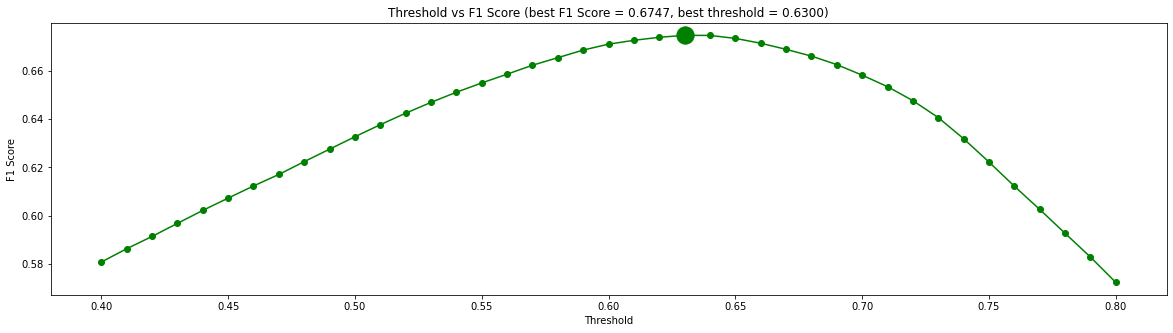

Threshold :    0.6300000000000002
F1-Score  :    0.6746636923180049


In [9]:
def find_best_threshold(pred, true, min = 0.4, max = 0.81, step = 0.01):
    scores = []
    best_score = 0
    best_threshold = 0
    
    true_label = true.to_numpy().flatten()
  
    thresholds = np.arange(min, max, step)
    for threshold in thresholds:
        predict = (pred.to_numpy().flatten() > threshold).astype('int')
        m = f1_score(true_label, predict, average = 'macro')
        scores.append(m)
        if m > best_score:
            best_score = m
            best_threshold = threshold

    plt.figure(figsize = (20, 5))
    plt.scatter([best_threshold], [best_score], color = 'g', s = 300)
    plt.plot(thresholds, scores, marker = 'o', color = 'g')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title(f'Threshold vs F1 Score (best F1 Score = {best_score:.4f}, best threshold = {best_threshold:.4f})')
    plt.show()

    return best_threshold, best_score

best_threshold, best_score = find_best_threshold(pred_df, true_df)
print(f'Threshold :    {best_threshold}')
print(f'F1-Score  :    {best_score}')

In [10]:
modified_pred_df = (pred_df > best_threshold).astype(int)
modified_pred_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
session_id,,,,,,,,,,,,,,,,,,
20090312431273200,1,1,1,1,0,1,1,1,1,0,1,1,0,1,0,1,1,1
20090312433251036,1,1,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1
20090312455206810,1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1,1
20090313091715820,1,1,1,1,0,1,1,1,1,0,1,1,0,1,0,1,1,1
20090313571836404,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1


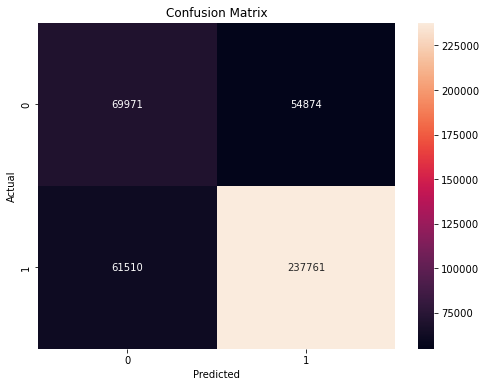

In [11]:
confusion = confusion_matrix(true_df.values.reshape((-1)), modified_pred_df.values.reshape((-1)))
plt.figure(figsize = (8, 6))
sns.heatmap(confusion, annot = True, fmt = 'd') 
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [12]:
for question in range(1, 19):
    m = f1_score(true_df[question - 1].values, (pred_df[question - 1].values > best_threshold).astype('int'), average = 'macro')
    print(f'Question {question:2}: F1 = ', m)
  
m = f1_score(true_df.values.reshape((-1)), (pred_df.values.reshape((-1)) > best_threshold).astype('int'), average = 'macro')
print('==> Overall F1 =', m)

Question  1: F1 =  0.5805690082834258
Question  2: F1 =  0.49463795470144134
Question  3: F1 =  0.48354419480966754
Question  4: F1 =  0.5856015391721763
Question  5: F1 =  0.5477008519614827
Question  6: F1 =  0.596915834788417
Question  7: F1 =  0.5717967979196379
Question  8: F1 =  0.529802426872903
Question  9: F1 =  0.5897807340235572
Question 10: F1 =  0.46082648278094057
Question 11: F1 =  0.5831196222549372
Question 12: F1 =  0.47408767887213454
Question 13: F1 =  0.4219320510388285
Question 14: F1 =  0.6002727683729772
Question 15: F1 =  0.42309412153590786
Question 16: F1 =  0.456927532952892
Question 17: F1 =  0.5296887542883817
Question 18: F1 =  0.48734796893017995
==> Overall F1 = 0.6746636923180049


## SUBMISSION

In [13]:
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

limits = {'0-4': (1, 4), '5-12': (4, 14), '13-22': (14, 19)}

for (test, sample_submission) in iter_test:
    test_df = feature_engineer(test, verbose = False)
    for level_group in test_df['level_group'].unique():
        test_ds = test_df[test_df['level_group'] == level_group].drop('level_group', axis = 1)
        if test_ds.shape[0] > 0:
            a, b = limits[level_group]
            for question in range(a, b):
                model = models[f'{level_group}_{question}']
                class_idx = list(model.classes_).index(1)
                mask = sample_submission['session_id'].str.endswith(f'q{question}')
                sample_submission.loc[mask,'correct'] = (model.predict_proba(test_ds)[:, class_idx] > best_threshold).astype('int').flatten()

    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [14]:
! head submission.csv

session_id,correct
20090109393214576_q1,1
20090109393214576_q2,1
20090109393214576_q3,1
20090109393214576_q4,1
20090109393214576_q5,0
20090109393214576_q6,1
20090109393214576_q7,1
20090109393214576_q8,0
20090109393214576_q9,1
